Ceci n'est pas un commentaire


# ***Google Captcha image recognition***
**A Deep Learning Project using TensorFlow**

*by Emma Begard, Augustin Bouveau, Bagin Jobert-Rollin, Hugues Boisdon*

## I Data **Fetching**

Our source Dataset can be found at : *https://www.kaggle.com/datasets/mikhailma/test-dataset*

*credits : **Mike Mazurov***

### I.1 **Dowloading** Dataset Files from ***KaggleHub*** Source

In [1]:
import kagglehub

DATA_FOLDER_PATH_IF_CACHED = kagglehub.dataset_download("mikhailma/test-dataset")
print("Path to dataset files in cache:", DATA_FOLDER_PATH_IF_CACHED)

c:\ProgramData\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files in cache: C:\Users\Development\.cache\kagglehub\datasets\mikhailma\test-dataset\versions\1


The data files are downloaded in the Users **cache** by default.
If the data source folder is moved, ***please update*** the following *path variable*

In [2]:
DATA_FOLDER_PATH_IF_MOVED = "" # Data folder path if data was moved since download

In [3]:
def getDataSourceFolderPath() -> str:
    return DATA_FOLDER_PATH_IF_CACHED if DATA_FOLDER_PATH_IF_MOVED == "" else DATA_FOLDER_PATH_IF_MOVED

def getImagesDataFolderPath() -> str:
    return getDataSourceFolderPath() +"/Google_Recaptcha_V2_Images_Dataset/images"

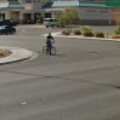

In [4]:
from PIL import Image
path = DATA_FOLDER_PATH_IF_CACHED if DATA_FOLDER_PATH_IF_MOVED == "" else DATA_FOLDER_PATH_IF_MOVED
Image.open(getImagesDataFolderPath() +"/Bicycle/Bicycle (1).png")

### I.2 **Loading** Training and Validation Datasets

In [5]:
from tensorflow.keras.utils import image_dataset_from_directory

BATCH_SIZE = 32
IMG_DIMENSIONS = (120, 120) # pixels per pixels
SEED_RANDOM = 123

VALIDATION_RATIO = 0.2

train_dataset = image_dataset_from_directory(
  getImagesDataFolderPath(),
  validation_split= VALIDATION_RATIO,
  subset= "training",
  
  seed=       SEED_RANDOM,
  image_size= IMG_DIMENSIONS,
  batch_size= BATCH_SIZE)

validation_dataset = image_dataset_from_directory(
  getImagesDataFolderPath(),
  validation_split= VALIDATION_RATIO,
  subset= "validation",
  
  seed=       SEED_RANDOM,
  image_size= IMG_DIMENSIONS,
  batch_size= BATCH_SIZE)

Found 11730 files belonging to 12 classes.
Using 9384 files for training.
Found 11730 files belonging to 12 classes.
Using 2346 files for validation.


The **keras** sublibrary of ***TensorFlow*** allow us to directly load our datasets (and ensure the size normalization of 120px per 120px for all images).

In [6]:
CLASS_NAMES = train_dataset.class_names
print(CLASS_NAMES)

['Bicycle', 'Bridge', 'Bus', 'Car', 'Chimney', 'Crosswalk', 'Hydrant', 'Motorcycle', 'Other', 'Palm', 'Stair', 'Traffic Light']


Our model is going to be guessing between these classes for each image.

#### Data Sample for Visualization  

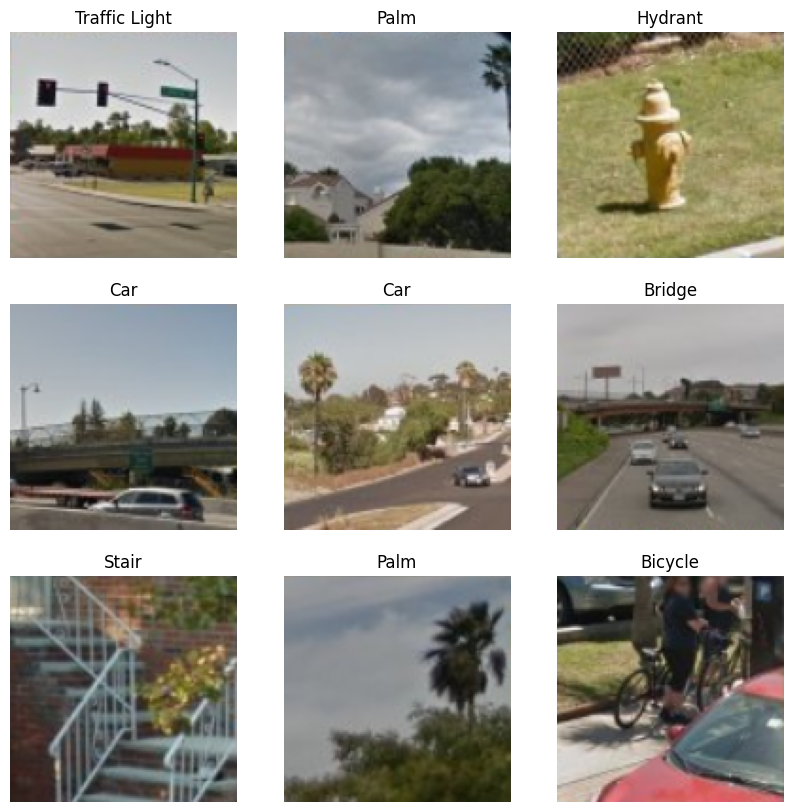

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(CLASS_NAMES[labels[i]])
    plt.axis("off")

## II Data **Preprocessing**

There is no further cleaning to do on the images and labels as they already are consistents, but we can define preprocessing layers as follows.

### II.1 **Normalization Layer** for pixel values

In [8]:
from tensorflow.keras.layers import Rescaling

def getNormalizationLayer():
    return Rescaling(1./255)

Pixel values will now be bound from 0 to 1 instead of 0 to 255.

### II.2 Data Augmentation Layers

In [9]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom

def getAugmentationLayers(maxRotation:float= 0.1, maxZoom:float= 0.1) -> Sequential:
    return Sequential(
    [
        RandomFlip("horizontal",
                        input_shape=(IMG_DIMENSIONS[0],
                                    IMG_DIMENSIONS[1],
                                    3)),
        RandomRotation(maxRotation),
        RandomZoom(maxZoom),
    ]
    )

C:\Users\Development\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


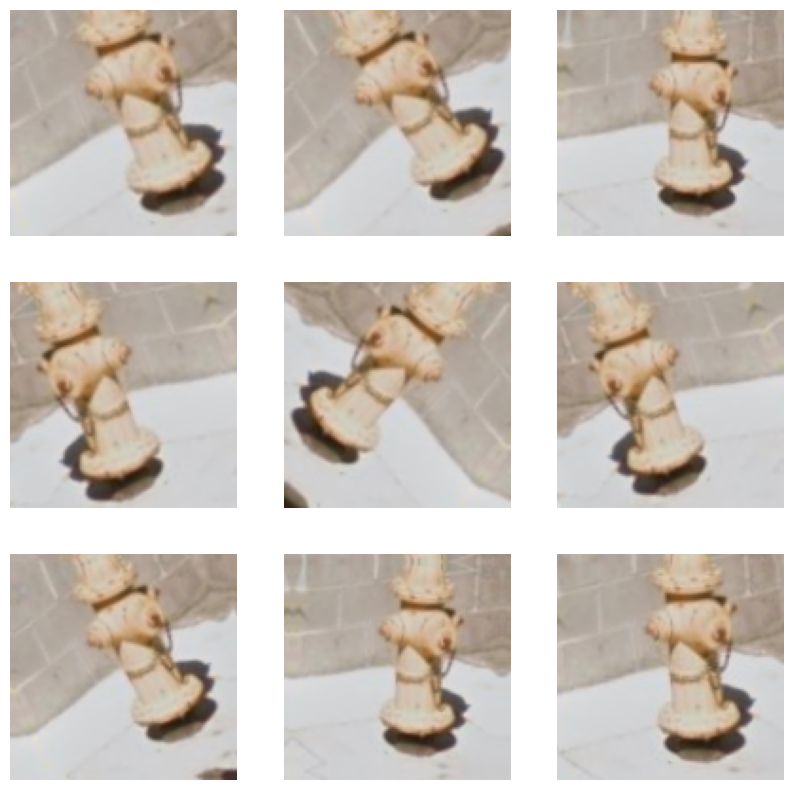

In [10]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
  for i in range(9):
    augmented_images = getAugmentationLayers()(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### II.2 **Optimizations** of Data memory caching, availibity and randomization

In [11]:
from tensorflow.data import AUTOTUNE

train_dataset_opti        = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset_opti   = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

## III **Designing** the *Models*

### III.1 First Model

#### III.1.A Defining and compiling the model

In [12]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

first_model = Sequential([
  getAugmentationLayers(),
  getNormalizationLayer(),
  Conv2D(16, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(len(CLASS_NAMES), name="outputs")
], name = "First_Model")

In [13]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

first_model.compile(optimizer='adam',
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

first_model.summary()

Model: "First_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_9 (Sequential)       │ (None, 120, 120, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 120, 120, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 120, 120, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 60, 60, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 60, 60, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,843,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,868,460 (7.13 MB)

 Trainable params: 1,868,460 (7.13 MB)

 Non-trainable params: 0 (0.00 B)

#### III.1.B Training the model

In [14]:
EPOCHS_FIRST= 10

first_history = first_model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=EPOCHS_FIRST
)

Epoch 1/10
 28/294 ━━━━━━━━━━━━━━━━━━━━ 32s 122ms/step - accuracy: 0.2159 - loss: 2.3242

KeyboardInterrupt: 

#### III.1.C Visualizing results

In [ ]:
acc = first_history.history['accuracy']
val_acc = first_history.history['val_accuracy']

loss = first_history.history['loss']
val_loss = first_history.history['val_loss']

epochs_range = range(EPOCHS_FIRST)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

NameError: name 'first_history' is not defined

### III.2 Second Model (with Dropout)

#### III.2.A Defining and compiling the model

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

second_model = Sequential([
  getAugmentationLayers(),
  getNormalizationLayer(),
  Conv2D(16, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Dropout(0.2),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(len(CLASS_NAMES), name="outputs")
], name = "Second_Model")

C:\Users\Development\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

second_model.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

second_model.summary()

#### III.2.B Training the model

In [ ]:
EPOCHS_SECOND = 15
second_history = second_model.fit(
  train_dataset,
  validation_data= validation_dataset,
  epochs=EPOCHS_SECOND
)

#### III.2.C Visualizing results

In [ ]:
acc = second_history.history['accuracy']
val_acc = second_history.history['val_accuracy']

loss = second_history.history['loss']
val_loss = second_history.history['val_loss']

epochs_range = range(EPOCHS_SECOND)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

NameError: name 'first_history' is not defined